# Seeding and Dataset Generator

In [90]:
#SEED ALL for reproducibility
from numpy.random import seed
import tensorflow
import torch #don't mind some torch operations -- just use the functions as-is :)

#please do not change the seed
cherrypicked_seed = 42

seed(cherrypicked_seed)
tensorflow.random.set_seed(cherrypicked_seed)
torch.manual_seed(cherrypicked_seed)

#essentials
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

import math

def get_samples(m, I, is_grid):
    if not is_grid:
        # Random points
        np.random.seed(1)
        X = np.random.uniform(I[0], I[1], (m, 2))
        X = torch.tensor(X, dtype=torch.float32)
    else:
        # Points on a grid
        n = round(math.sqrt(m))
        grd =  torch.linspace(I[0], I[1], n)
        x1, x2 = torch.meshgrid(grd, grd)
        x1 = x1.flatten().unsqueeze(1)
        x2 = x2.flatten().unsqueeze(1)
        X = torch.cat((x1, x2), dim=1)

    return X

def checkerboard_problem(m=20000, nrows=8, ncols=8, nclasses=2, I=[-1., 1.], is_grid=False):
    """
    checkerboard problem dataset
    """
    X = get_samples(m, I, is_grid)
    X_ = X.clone()
    if 0 != I[0] or 1 != I[1]:
        # Map to [0, 1] domain for computing labels
        X_ -= I[0]
        X_.div_(I[1] - I[0])
    x1 = X_[:, 0]
    x2 = X_[:, 1]
    col = (x1 * ncols).long()
    row = (x2 * nrows).long()
    ix = col + row * ncols
    if 0 == ncols % nclasses:
        ix += (row % 2)
    y = ix % nclasses
    # X -= 0.5
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.uint8)
    return X.numpy(), y.long().numpy()

# The Dataset


The provided dataset is a simulation of a checkerboard problem, and you are asked to perform a binary classification task (distinguish between black and white cells) 

you can use the generator function `checkerboard_problem` as-is, please do not change the generating parameters.


In [91]:
X, y = checkerboard_problem(m = 2000, nrows = 6, ncols = 6, nclasses = 2, I = [10,20])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


##Inspecting the data

any comment about data dimensionality/distribution/feature range goes here, together with a visualization of the provided dataset

In [92]:
# checking data dimensionality
X.shape, y.shape

((2000, 2), (2000,))

In [93]:
# looking at some example samples
X[0:2], y[0:2]

(array([[14.17022 , 17.203245],
        [10.001143, 13.023326]], dtype=float32), array([0, 1]))

In [94]:
np.unique(y)

array([0, 1])

As expected since it is binary classification



In [95]:
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['target'] = y

df

,x1,x2,target
0,14.170220,17.203245,0
1,10.001143,13.023326,1
2,11.467559,10.923386,0
3,11.862602,13.455607,1
4,13.967675,15.388167,1
...,...,...,...
1995,10.943726,18.993685,1
1996,10.677709,16.807024,0
1997,19.719982,17.093739,1
1998,13.259088,10.734402,1


In [96]:
df.describe()

,x1,x2,target
count,2000.000000,2000.000000,2000.000000
mean,14.963929,15.063548,0.494000
std,2.880753,2.881764,0.500089
min,10.001143,10.000970,0.000000
25%,12.479584,12.544340,0.000000
50%,15.034081,15.121202,0.000000
75%,17.430386,17.555056,1.000000
max,19.985991,19.998758,1.000000


All the information we see quickly can see here. Some to point out:
 - x1 and x2 are almost equally distributed, so maybe it doesn't even need to be normalized
 - there are almost the same number of 0s and 1s in the target (also good)
 - x1 and x2 are more or less from the range of 10 to 20, so we could say that they are biased, therefor I think we would need normalization

### Visualisation

In [97]:
# borrowed function from labs :)

def plot_data(data, labels, title = "nonlinear data"):
    # Generate scatter plot for training data
    fig, ax = plt.subplots(figsize=(10,10))
    for g in np.unique(labels):
        i = np.where(labels == g)
        ax.scatter(data[i,0], data[i,1], label=g)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    
    plt.show()

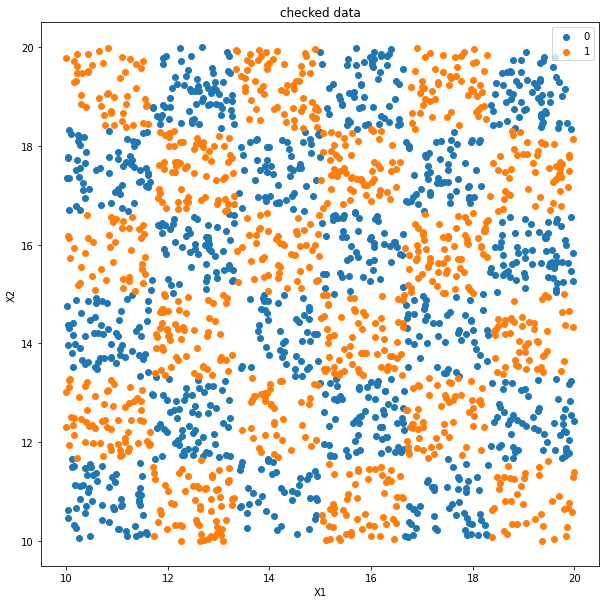

In [98]:
plot_data(X, y, title='checked data')

## Preparing the data

In [99]:
# taking scaler cause it has bias
# as first peek I have choosen standard scaler from sklearn
from sklearn.preprocessing import StandardScaler

print(X[0:10])

scaler = StandardScaler()
X = scaler.fit_transform(X)

X[0:10]

[[14.17022  17.203245]
 [10.001143 13.023326]
 [11.467559 10.923386]
 [11.862602 13.455607]
 [13.967675 15.388167]
 [14.191945 16.852196]
 [12.044522 18.781174]
 [10.273876 16.704676]
 [14.173048 15.586898]
 [11.40387  11.981015]]


array([[-0.27559012,  0.74268144],
       [-1.7231698 , -0.7081537 ],
       [-1.2140036 , -1.4370356 ],
       [-1.0768372 , -0.55811036],
       [-0.3459175 ,  0.11267439],
       [-0.26804692,  0.62083346],
       [-1.0136713 ,  1.2903749 ],
       [-1.628472  ,  0.5696297 ],
       [-0.2746083 ,  0.18165304],
       [-1.2361176 , -1.069936  ]], dtype=float32)

In [100]:
np.min(X), np.max(X), np.mean(X)

(-1.7572029, 1.7437514, -6.6757204e-09)

### Normalization summary
Now we have numbers in the range -1.75 to 1.75 which is way better, because NNs learn better on smaller values . We also get rid of the bias. We can see the mean is almost 0 (small numeric value). Good news!

Later on, if this result is satisfying I will try to use another scaler or even without any.

In [101]:
from sklearn.model_selection import train_test_split


# deviding the data set into train and test 
# optimal 20% of test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [102]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1600, 2), (1600,), (400, 2), (400,))

Everything worked out :)

We can start learning...

## Building the network and training

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

make sure to visualize the evolution of decision boundaries during the training, as well as to visualize the network history in terms of loss and metrics (can be done either during the training or after the training is done).

Note: We advice to visualize the decision boundaries only every n_epochs-th (e.g. every 5th/10th epoch), to speed up your training.

In [103]:
# imports
import tensorflow as tf
import keras
from keras.layers import Dense

### Building the rectangular network


In [104]:
model = tf.keras.Sequential()

input_shape = (2,)
n_epochs = 256

# FIRST TRY: rectangular shape, it is said to be usually the best
# I have tried rectangle with 3 layers of 32 neurons each, but it didnt work well

# All layers except the last one have ReLU activation
# If something will not work well I am going to change it
model.add(Dense(32, activation="relu", input_shape=input_shape))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))

# since it is binary classification I use one neuron at the last layer and sigmoid
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 32)                96        
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [105]:
# accuracy is the basic metric for classification
# and binary crossentropy is a obviuos peak
# I have tried SGD optimizer, but it didn't work well 
# it went up to 60% of accuracy after around 20 epochs and then oscillate until the end of learning
# ADAM is doing much better
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [106]:
# the problem is quite cheap computationally so we can have bigger number of epochs
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=16, validation_split=0.1)

Epoch 1/256
90/90 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5076 - val_loss: 0.6874 - val_accuracy: 0.5813
Epoch 2/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6895 - accuracy: 0.5271 - val_loss: 0.6856 - val_accuracy: 0.6250
Epoch 3/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5215 - val_loss: 0.6837 - val_accuracy: 0.5562
Epoch 4/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6849 - accuracy: 0.5354 - val_loss: 0.6768 - val_accuracy: 0.5813
Epoch 5/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5632 - val_loss: 0.6781 - val_accuracy: 0.5750
Epoch 6/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.5708 - val_loss: 0.6742 - val_accuracy: 0.5813
Epoch 7/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6755 - accuracy: 0.5785 - val_loss: 0.6712 - val_accuracy: 0.5688
Epoch 8/256
9

In [107]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.4241 - accuracy: 0.8100


[0.4241388738155365, 0.8100000023841858]

### Triangular approach

In [108]:
model = tf.keras.Sequential()

# SECOND TRY: triangle shape, it is said to be usually the best
# Keep it mind that is has simillar number of params

# SAME AS BEFORE
# All layers except the last one have ReLU activation
# If something will not work well I am going to change it
model.add(Dense(62, activation="relu", input_shape=input_shape))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))

# since it is binary classification I use one neuron at the last layer and sigmoid
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 62)                186       
                                                                 
 dense_32 (Dense)            (None, 32)                2016      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,747
Trainable params: 2,747
Non-trainable params: 0
_________________________________________________________________


In [109]:
# SAME AS BEFORE
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [110]:
# the problem is quite cheap computationally so we can have bigger number of epochs
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=16, validation_split=0.1)

Epoch 1/256
90/90 [==============================] - 1s 4ms/step - loss: 0.6967 - accuracy: 0.4840 - val_loss: 0.6878 - val_accuracy: 0.5750
Epoch 2/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6913 - accuracy: 0.5090 - val_loss: 0.6877 - val_accuracy: 0.5562
Epoch 3/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5333 - val_loss: 0.6855 - val_accuracy: 0.5250
Epoch 4/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5285 - val_loss: 0.6790 - val_accuracy: 0.5938
Epoch 5/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6878 - accuracy: 0.5375 - val_loss: 0.6830 - val_accuracy: 0.5437
Epoch 6/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5278 - val_loss: 0.6823 - val_accuracy: 0.5813
Epoch 7/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.5562 - val_loss: 0.6810 - val_accuracy: 0.5688
Epoch 8/256
9

In [111]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.3761 - accuracy: 0.8275


[0.37611258029937744, 0.8274999856948853]

### Testing other architecture
Since the worked pretty well we can try to learn a simpler model. We are going to stick to the triangular architecture, despite fact both of them are performing similarly. Also triangular is usually better in classification problems.


In [112]:
model_simpler = tf.keras.Sequential()


# Maybe the simpler network is enough
model_simpler.add(Dense(64, activation="relu", input_shape=input_shape))
model_simpler.add(Dense(32, activation="relu"))

# since it is binary classification I use one neuron at the last layer and sigmoid
model_simpler.add(Dense(1, activation="sigmoid"))

model_simpler.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                192       
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [113]:
model_simpler.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_simpler = model_simpler.fit(X_train, y_train, epochs=n_epochs, batch_size=16, validation_split=0.1)

Epoch 1/256
90/90 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5021 - val_loss: 0.6883 - val_accuracy: 0.5188
Epoch 2/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5292 - val_loss: 0.6890 - val_accuracy: 0.5500
Epoch 3/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6873 - accuracy: 0.5514 - val_loss: 0.6892 - val_accuracy: 0.5063
Epoch 4/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5437 - val_loss: 0.6836 - val_accuracy: 0.5938
Epoch 5/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6854 - accuracy: 0.5472 - val_loss: 0.6854 - val_accuracy: 0.5500
Epoch 6/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5292 - val_loss: 0.6874 - val_accuracy: 0.5500
Epoch 7/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6825 - accuracy: 0.5556 - val_loss: 0.6893 - val_accuracy: 0.4938
Epoch 8/256
9

In [114]:
# again, code reusage ;)

x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

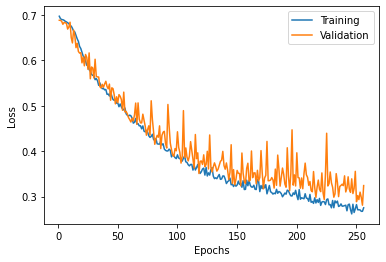

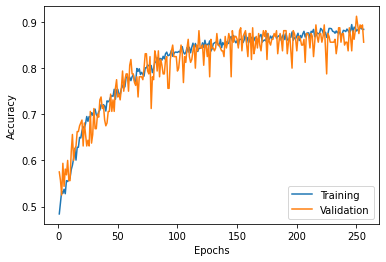

In [115]:
plot_history(history)

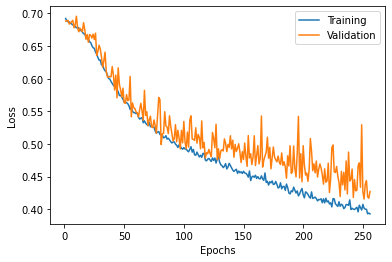

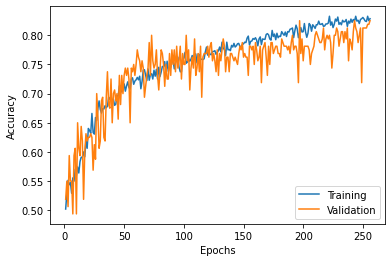

In [116]:
plot_history(history_simpler)

In [117]:
model.evaluate(X_test, y_test), model_simpler.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.4835 - accuracy: 0.7925


([0.37611258029937744, 0.8274999856948853],
 [0.4835297763347626, 0.7925000190734863])

We can see that the second one learn much slower and probably the first one reach its maximum accuracy (as it is faltening). Therefor maybe even more complex network will work even better...

Let find it out!

In [118]:
complex_model = tf.keras.Sequential()

complex_model.add(Dense(256, activation="relu", input_shape=input_shape))
complex_model.add(Dense(128, activation="relu"))
complex_model.add(Dense(64, activation="relu"))

# since it is binary classification I use one neuron at the last layer and sigmoid
complex_model.add(Dense(1, activation="sigmoid"))

complex_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 256)               768       
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


In [119]:
complex_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_complex = complex_model.fit(X_train, y_train, epochs=n_epochs, batch_size=16, validation_split=0.1)

Epoch 1/256
90/90 [==============================] - 1s 4ms/step - loss: 0.6959 - accuracy: 0.4931 - val_loss: 0.6876 - val_accuracy: 0.5688
Epoch 2/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5097 - val_loss: 0.6918 - val_accuracy: 0.5375
Epoch 3/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6906 - accuracy: 0.5278 - val_loss: 0.6887 - val_accuracy: 0.6187
Epoch 4/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6894 - accuracy: 0.5396 - val_loss: 0.6859 - val_accuracy: 0.5688
Epoch 5/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.5437 - val_loss: 0.6845 - val_accuracy: 0.5625
Epoch 6/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5389 - val_loss: 0.6837 - val_accuracy: 0.5625
Epoch 7/256
90/90 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.5917 - val_loss: 0.6747 - val_accuracy: 0.5375
Epoch 8/256
9

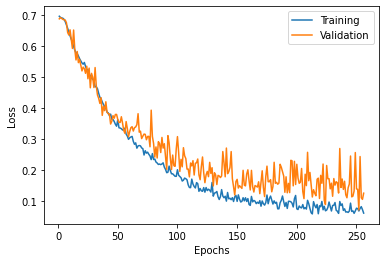

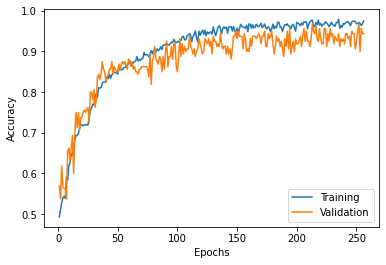

In [120]:
plot_history(history_complex)

### Succes
We can see higher accuracy on the training set, but validation stacks around 95%. That means we have overfitting! Our model might be a little bit too complex, but we should NOT worry about it, since the loss function did not start to raise.

3888/3888 [==============================] - 6s 1ms/step


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'complex model')

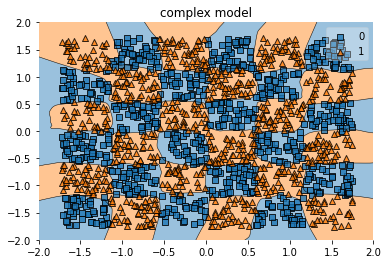

In [121]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_train, y_train, clf=complex_model)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("complex model")

3888/3888 [==============================] - 6s 2ms/step


Text(0.5, 1.0, 'zoomed complex model')

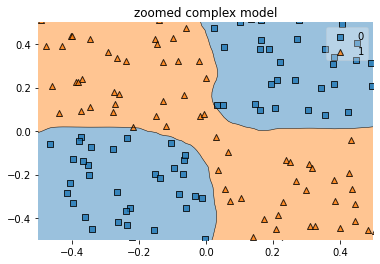

In [122]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_train, y_train, clf=complex_model)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.title("zoomed complex model")

3888/3888 [==============================] - 6s 1ms/step


Text(0.5, 1.0, 'simpler model')

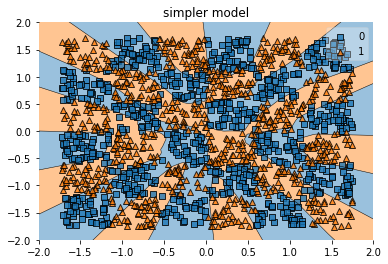

In [123]:
plot_decision_regions(X_train, y_train, clf=model_simpler)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("simpler model")

### An observation
Even if the problem may seem to be easy for the human brain, as we see on the plot above it, NN struggle a little bit with it because it is very hard to pick (compute) the decision boundaries. In some sense, it is very similar to the XOR problem, which also can be considered as trivial one. In both cases, we have data, which makes separate groups diagonal to each other, but close to each other. This problem is just more complex. It is like XOR which can take values from 10 to 20 (before scaling) and return 0 or 1. That is why by increasing a complexity we obtain better result.

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results, including some considerations about generalization to a VALIDATON set (that should be monitored during the training). Any comment on decision boundaries goes here.

In [124]:
# DONE ABOVE

## Validate the model and comment the results

please describe the evaluation procedure on a TEST set, commenting the generalization capability of your model (e.g. under/overfitting). 

Visualize your test performances as shown in the practical lab sessions.

Briefly describe the set of performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) for this taks, according to you? Why?

In [125]:
model.evaluate(X_test, y_test), model.metrics_names

13/13 [==============================] - 0s 3ms/step - loss: 0.3761 - accuracy: 0.8275


([0.37611258029937744, 0.8274999856948853], ['loss', 'accuracy'])

In [126]:
model_simpler.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.4835 - accuracy: 0.7925


[0.4835297763347626, 0.7925000190734863]

In [127]:
complex_model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.2080 - accuracy: 0.9175


[0.2079959511756897, 0.9175000190734863]

### Evaluation summary
The second model has underfitting (too simple) and the first and third overfitting, as mentioned before. Here it is confirmed because train accuracy is higher than the test. Also, the loss function is lower than during the training. In both overfitting cases we don't have to worry at all because of two main reasons:
- The loss function didn't start going up. In the first model it is even still going down (that is also, why I decided to create a more complex model)
- We know what the data set and decision boundaries look like. The clusters aren't intersecting each other, and as long as the boundaries between checkerboard squares don't get too twisty (we can see on the zoomed plot that it isn't) we shouldn't worry. I have tried to overfit in ordet to get the snake shape there but didn't work. Probably to less time and GPU power.

Therefore, from now I will just stick too the last (the complex) model as the best one.

## Make predictions (on the test set) and visualize them.

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on a possible external test set? Briefly motivate your answer.

In [128]:
y_predicted = complex_model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [129]:
y_predicted = y_predicted[:, 0]
y_predicted = y_predicted > 0.5

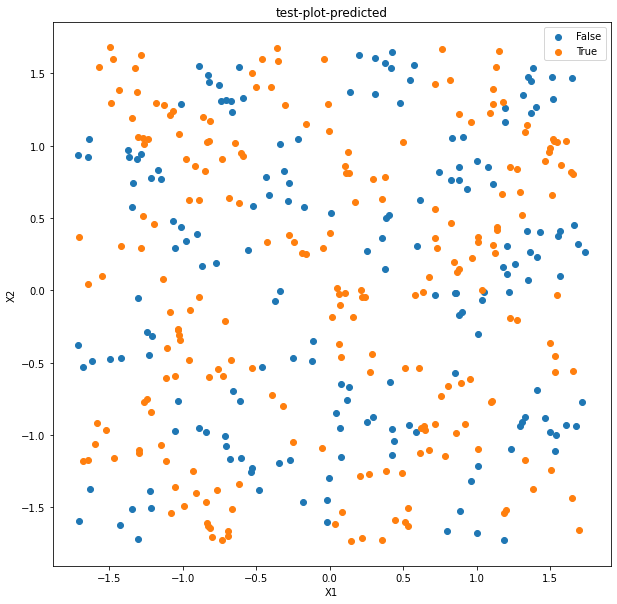

In [130]:
plot_data(X_test, y_predicted, title="test-plot-predicted")

### Expetations vs reality
We expected to see a checker board, but it isn't clearly visiable here. For sure we can see the decision boundaries ploted above. 

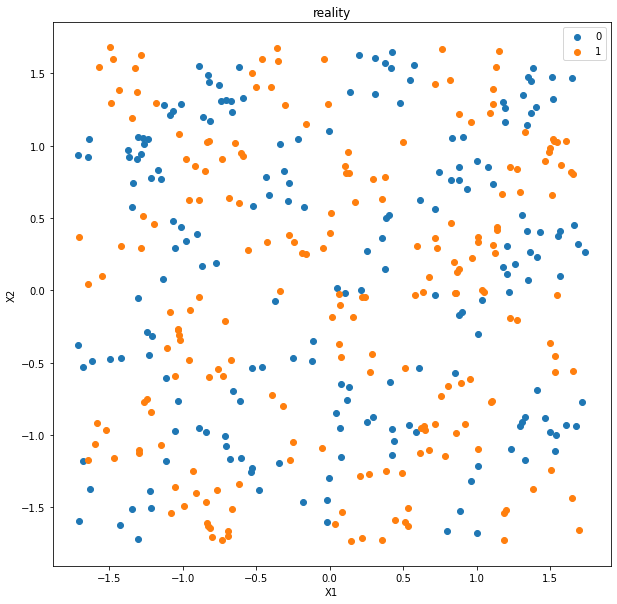

In [131]:
# let's see how it should look like
plot_data(X_test, y_test, title="reality")

Here the checks are way more visiable, since it was ploted from orginal y.

# Improve the results (if needed)

In case you are not satisfied by the results obtained previously, here goes any additional attempt. 

It can be either training longer the same model with the same or a different batch_size, or changing network hyperparameters or optimization settings (please do not change the generated dataset's parameter).

Please report here only the most successful experiment, but you can still (briefly) describe any others you have done and their results.

In [132]:
# PARTLY DONE ABOVE BUT STILL SOME EXPERIMENTS BELOW

In [133]:
thebest_model = tf.keras.Sequential()

# the same architecture
thebest_model.add(Dense(256, activation="relu", input_shape=input_shape))
thebest_model.add(Dense(128, activation="relu"))
thebest_model.add(Dense(64, activation="relu"))

thebest_model.add(Dense(1, activation="sigmoid"))

thebest_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               768       
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 1)                 65        
                                                                 
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
_________________________________________________________________


In [134]:
# I will experiment with the hyperparameters
thebest_model.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"])

In [135]:
# I will experiment with the hyperparameter- batch_size
history_thebest = thebest_model.fit(X_train, y_train, epochs=n_epochs, batch_size=8, validation_split=0.1)

Epoch 1/256
180/180 [==============================] - 2s 4ms/step - loss: 0.6970 - accuracy: 0.5250 - val_loss: 0.6829 - val_accuracy: 0.5688
Epoch 2/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.5111 - val_loss: 0.6865 - val_accuracy: 0.5625
Epoch 3/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6910 - accuracy: 0.5160 - val_loss: 0.6786 - val_accuracy: 0.6187
Epoch 4/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6815 - accuracy: 0.5618 - val_loss: 0.6606 - val_accuracy: 0.6000
Epoch 5/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6679 - accuracy: 0.5819 - val_loss: 0.6492 - val_accuracy: 0.5750
Epoch 6/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6500 - accuracy: 0.6132 - val_loss: 0.6295 - val_accuracy: 0.5875
Epoch 7/256
180/180 [==============================] - 1s 3ms/step - loss: 0.6292 - accuracy: 0.6319 - val_loss: 0.6097 - val_accuracy: 0.6375

In [136]:
thebest_model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.8600


[0.5119823217391968, 0.8600000143051147]

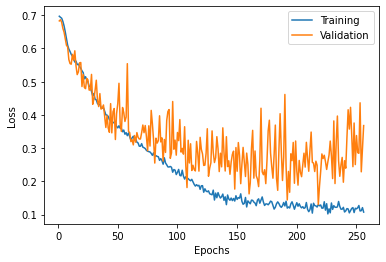

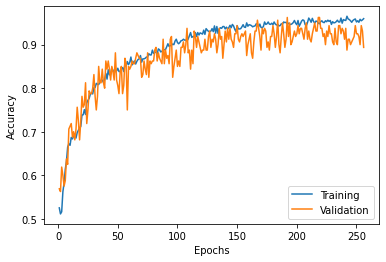

In [137]:
plot_history(history_thebest)

3888/3888 [==============================] - 6s 1ms/step


(-2.0, 2.0)

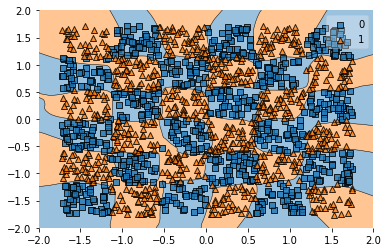

In [138]:
plot_decision_regions(X_train, y_train, clf=thebest_model)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

### Succes?
The best model performs similarly to the complex one. I played with the batch size and changed the optimizer, but it only affected learning speed. I think the performance was already quite good, so we could not really expect anything spectacular.

## Overall summary
As we could have seen the problem wasn't as easy for the FNN as it may seem. As I mentioned earlier, there is a noticeable resemblance between this and the XOR problem. That's why we get better performance with more complex networks. I wish I had more computational power to try to get accuracy around 100% (since there are no outliers it should be possible from the mathematical point of view). Nevertheless, I am satisfied with obtained results. 

# OPTIONAL

Decrease the number of samples to m = 1000, and increase the frequency of the checkerboard by setting ncols = 20, nrows = 20.

Then try to replicate the training dynamics, observe and comment the results in terms of fitting-capacity (performances during the training) and generalization (on the val & test set).

What are the differences? What is causing them (if any), according to you?

In [139]:
X, y = checkerboard_problem(m = 1000, nrows = 20, ncols = 20, nclasses = 2, I = [10,20])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


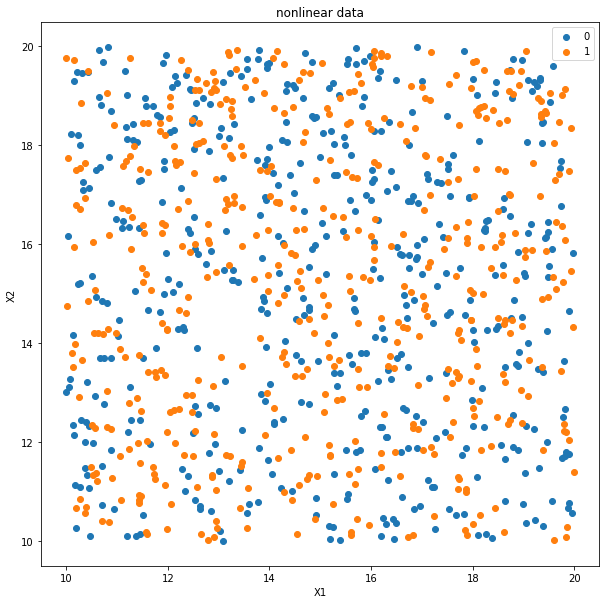

In [140]:
plot_data(X, y)

Looking at the plot it seems like it will be impossible to get any satisfying results, but why not try!



In [141]:
# all same as before
print(X[0:10])

scaler = StandardScaler()
X = scaler.fit_transform(X)

X[0:10]

[[14.17022  17.203245]
 [10.001143 13.023326]
 [11.467559 10.923386]
 [11.862602 13.455607]
 [13.967675 15.388167]
 [14.191945 16.852196]
 [12.044522 18.781174]
 [10.273876 16.704676]
 [14.173048 15.586898]
 [11.40387  11.981015]]


array([[-0.28644562,  0.68569326],
       [-1.7332742 , -0.7390455 ],
       [-1.2243721 , -1.4548168 ],
       [-1.087277  , -0.59170103],
       [-0.3567365 ,  0.06701819],
       [-0.27890632,  0.5660369 ],
       [-1.0241438 ,  1.2235352 ],
       [-1.6386255 ,  0.5157542 ],
       [-0.28546432,  0.13475609],
       [-1.2464747 , -1.0943204 ]], dtype=float32)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 2), (800,), (200, 2), (200,))

In [143]:
model_extra = tf.keras.Sequential()

# SECOND TRY: triangle shape, it is said to be usually the best
# Keep it mind that is has simillar number of params

# SAME AS BEFORE
# All layers except the last one have ReLU activation
# If something will not work well I am going to change it
model_extra.add(Dense(62, activation="relu", input_shape=input_shape))
model_extra.add(Dense(32, activation="relu"))
model_extra.add(Dense(16, activation="relu"))

# since it is binary classification I use one neuron at the last layer and sigmoid
model_extra.add(Dense(1, activation="sigmoid"))

model_extra.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 62)                186       
                                                                 
 dense_47 (Dense)            (None, 32)                2016      
                                                                 
 dense_48 (Dense)            (None, 16)                528       
                                                                 
 dense_49 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,747
Trainable params: 2,747
Non-trainable params: 0
_________________________________________________________________


In [144]:
model_extra.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model_extra.fit(X_train, y_train, epochs=n_epochs, batch_size=16, validation_split=0.1)

Epoch 1/256
45/45 [==============================] - 1s 6ms/step - loss: 0.6988 - accuracy: 0.4500 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/256
45/45 [==============================] - 0s 3ms/step - loss: 0.6911 - accuracy: 0.5250 - val_loss: 0.6953 - val_accuracy: 0.4750
Epoch 3/256
45/45 [==============================] - 0s 3ms/step - loss: 0.6905 - accuracy: 0.5236 - val_loss: 0.6966 - val_accuracy: 0.4750
Epoch 4/256
45/45 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5181 - val_loss: 0.6980 - val_accuracy: 0.5250
Epoch 5/256
45/45 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5417 - val_loss: 0.6991 - val_accuracy: 0.4625
Epoch 6/256
45/45 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5361 - val_loss: 0.6982 - val_accuracy: 0.5250
Epoch 7/256
45/45 [==============================] - 0s 3ms/step - loss: 0.6881 - accuracy: 0.5375 - val_loss: 0.6991 - val_accuracy: 0.4750
Epoch 8/256
4

In [145]:
model_extra.evaluate(X_train, y_train)

25/25 [==============================] - 0s 3ms/step - loss: 0.6320 - accuracy: 0.6200


[0.631966233253479, 0.6200000047683716]

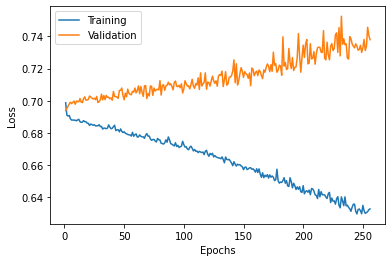

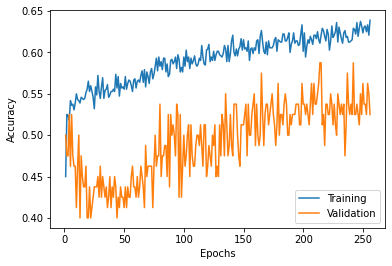

In [146]:
plot_history(history)

3888/3888 [==============================] - 6s 1ms/step


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'the extra model')

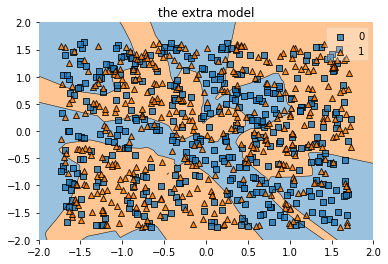

In [147]:
plot_decision_regions(X_train, y_train, clf=model_extra)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("the extra model")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


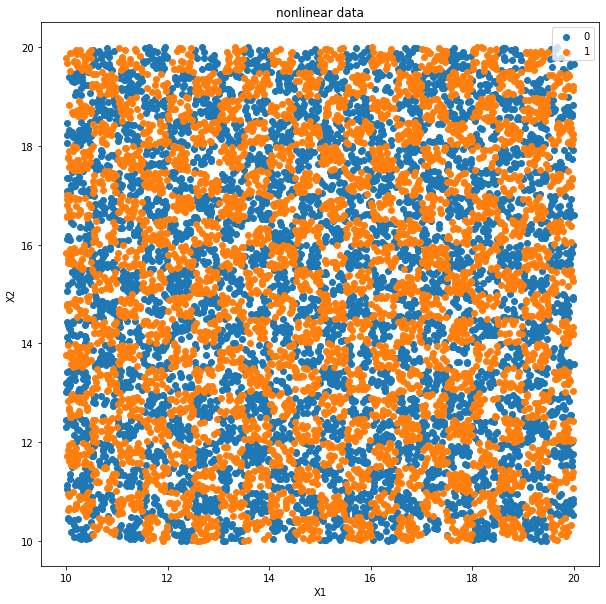

In [148]:
X_dense, y_dense = checkerboard_problem(m = 10000, nrows = 20, ncols = 20, nclasses = 2, I = [10,20])
plot_data(X_dense, y_dense)

### As expected...
Since the data didn't have a pattern anymore it was impossible to learn on this set. There are to less samples and too many columns and rows in the checkerboard (they are too dense) and because of the noise they just become a set of random 2D vectors.